In [1]:
#kaggle kernel learning
from sklearn import svm , tree,linear_model ,neighbors,naive_bayes , ensemble , discriminant_analysis , gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
import pandas as pd

In [3]:
data_raw = pd.read_csv('train.csv')

In [4]:
data_val = pd.read_csv('test.csv')

In [5]:
data1 = data_raw.copy()

In [6]:
data_cleaner = [data1 , data_val] #训练数据 测试数据合在一起

In [7]:
data_raw.sample(4) #随机采样4个

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
202,203,0,3,"Johanson, Mr. Jakob Alfred",male,34.0,0,0,3101264,6.4958,NaN,S
434,435,0,1,"Silvey, Mr. William Baird",male,50.0,1,0,13507,55.9000,E44,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S


In [8]:
data_raw.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Shutes, Miss. Elizabeth W",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [9]:
#缺失值的填充
for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median() , inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0] , inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median() , inplace=True)

drop_column = ['PassengerId' , 'Cabin' , 'Ticket']

data1.drop(drop_column , axis = 1 , inplace=True)

In [10]:
data_raw.Sex.mode()

0    male
dtype: object

In [11]:
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] >1 ] = 0
    
    dataset['Title'] = dataset['Name'].str.split(', ' , expand=True)[1].str.split('.' , expand=True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'] , 4)
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int) , 5)


stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] ==True else x)


I:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
data1['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [13]:
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])    
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])    
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])    
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin']) 

Target = ['Survived']

data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x

data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy

data1_dummy

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0
5,3,0,0,28.0,8.4583,1,1,0,1,0,1,0,0,0,0,1,0
6,1,0,0,54.0,51.8625,1,1,0,1,0,0,1,0,0,0,1,0
7,3,3,1,2.0,21.0750,5,0,0,1,0,0,1,1,0,0,0,0
8,3,0,2,27.0,11.1333,3,0,1,0,0,0,1,0,0,0,0,1
9,2,1,0,14.0,30.0708,2,0,1,0,1,0,0,0,0,0,0,1


In [14]:
data_cleaner[0].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1


In [15]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

In [16]:
data1_x

['Sex',
 'Pclass',
 'Embarked',
 'Title',
 'SibSp',
 'Parch',
 'Age',
 'Fare',
 'FamilySize',
 'IsAlone']

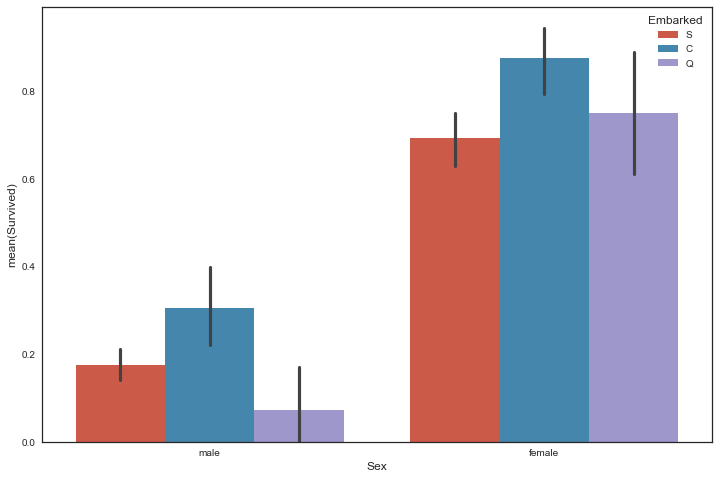

In [17]:
#fig, qaxis = plt.subplots(figsize=(14,12))
#sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1)
sns.barplot(x = data1['Sex'], y = data1['Survived'], hue = data1['Embarked'])#, data=data1)

In [18]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    gaussian_process.GaussianProcessClassifier(),
    
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(), #感知机
    
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability = True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier()
]

In [19]:
for index , row in data1.iterrows():
    print(index , row)

0 Survived                               0
Pclass                                 3
Name             Braund, Mr. Owen Harris
Sex                                 male
Age                                   22
SibSp                                  1
Parch                                  0
Fare                                7.25
Embarked                               S
FamilySize                             2
IsAlone                                0
Title                                 Mr
FareBin                   (-0.001, 7.91]
AgeBin                      (16.0, 32.0]
Sex_Code                               1
Embarked_Code                          2
Title_Code                             3
AgeBin_Code                            1
FareBin_Code                           0
Name: 0, dtype: object
1 Survived                                                         1
Pclass                                                           1
Name             Cumings, Mrs. John Bradley (Florence Briggs

61 Survived                           1
Pclass                             1
Name             Icard, Miss. Amelie
Sex                           female
Age                               38
SibSp                              0
Parch                              0
Fare                              80
Embarked                           S
FamilySize                         1
IsAlone                            1
Title                           Miss
FareBin              (31.0, 512.329]
AgeBin                  (32.0, 48.0]
Sex_Code                           0
Embarked_Code                      2
Title_Code                         2
AgeBin_Code                        2
FareBin_Code                       3
Name: 61, dtype: object
62 Survived                                   0
Pclass                                     1
Name             Harris, Mr. Henry Birkhardt
Sex                                     male
Age                                       45
SibSp                                     

Name: 191, dtype: object
192 Survived                                                       1
Pclass                                                         3
Name             Andersen-Jensen, Miss. Carla Christine Nielsine
Sex                                                       female
Age                                                           19
SibSp                                                          1
Parch                                                          0
Fare                                                      7.8542
Embarked                                                       S
FamilySize                                                     2
IsAlone                                                        0
Title                                                       Miss
FareBin                                           (-0.001, 7.91]
AgeBin                                              (16.0, 32.0]
Sex_Code                                                     

299 Survived                                                       1
Pclass                                                         1
Name             Baxter, Mrs. James (Helene DeLaudeniere Chaput)
Sex                                                       female
Age                                                           50
SibSp                                                          0
Parch                                                          1
Fare                                                     247.521
Embarked                                                       C
FamilySize                                                     2
IsAlone                                                        0
Title                                                        Mrs
FareBin                                          (31.0, 512.329]
AgeBin                                              (48.0, 64.0]
Sex_Code                                                       0
Embarked_Code        

498 Survived                                                       0
Pclass                                                         1
Name             Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
Sex                                                       female
Age                                                           25
SibSp                                                          1
Parch                                                          2
Fare                                                      151.55
Embarked                                                       S
FamilySize                                                     4
IsAlone                                                        0
Title                                                        Mrs
FareBin                                          (31.0, 512.329]
AgeBin                                              (16.0, 32.0]
Sex_Code                                                       0
Embarked_Code        

In [20]:
import random

In [21]:
for index , row in data1.iterrows():
    if random.random()>0.5:
        data1.set_value(index , 'Random_Predict' , 1)
    else:
        data1.set_value(index , 'Random_Predict' , 0)
    
data1['Random_Score'] = 0
data1.loc[(data1.Survived == data1['Random_Predict']), 'Random_Score'] = 1
print('random guess %.2f' % (data1['Random_Score'].mean()))

random guess 0.49


In [22]:
metrics.accuracy_score(data1.Survived , data1.Random_Predict)

0.48709315375982043

In [23]:
pivot_female = data1[data1.Sex == 'female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
pivot_female

Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000
                          (14.454, 31.0]

In [24]:
pivot_male = data1[data1.Sex == 'male'].groupby(['Sex','Title'])['Survived'].mean()
pivot_male

Sex   Title 
male  Master    0.575000
      Misc      0.250000
      Mr        0.156673
Name: Survived, dtype: float64

In [25]:
def mytree(df):
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master']
    
    for index , row in df.iterrows():
        Model.loc[index , 'Predict'] = 0
        
        if df.loc[index , 'Sex'] == 'female':
            Model.loc[index , 'Predict'] = 1
        
        if ((df.loc[index , 'Sex'] == 'female')&
        (df.loc[index , 'Pclass'] == 3) &
        (df.loc[index , 'Embarked'] == 'S') &
        (df.loc[index , 'Fare'] > 8)):
            Model.loc[index , 'Predict'] = 0
        
        if ((df.loc[index , 'Sex'] == 'male') &
        (df.loc[index , 'Title'] in male_title)):
            Model.loc[index , 'Predict'] = 1
            
    return Model

In [26]:
Tree_Predict = mytree(data1)
metrics.accuracy_score(data1['Survived'] , Tree_Predict)

0.8204264870931538

In [27]:
print(metrics.classification_report(data1.Survived , Tree_Predict))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



no normalize
[[497  52]
 [108 234]]
have normalize
[[0.91 0.09]
 [0.32 0.68]]


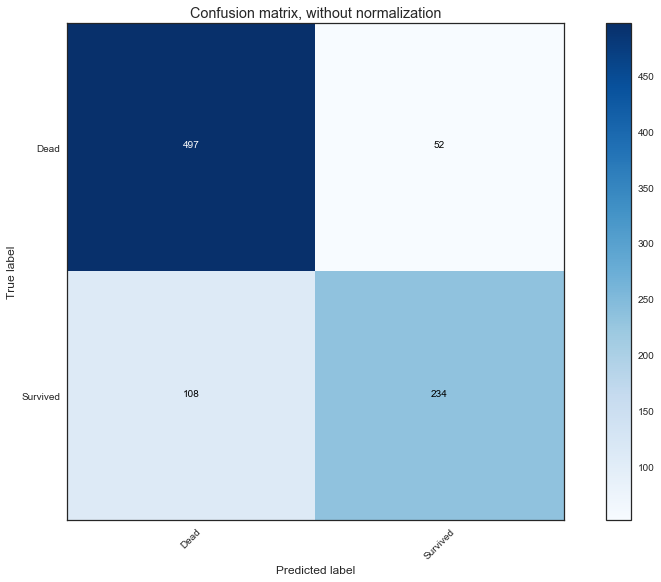

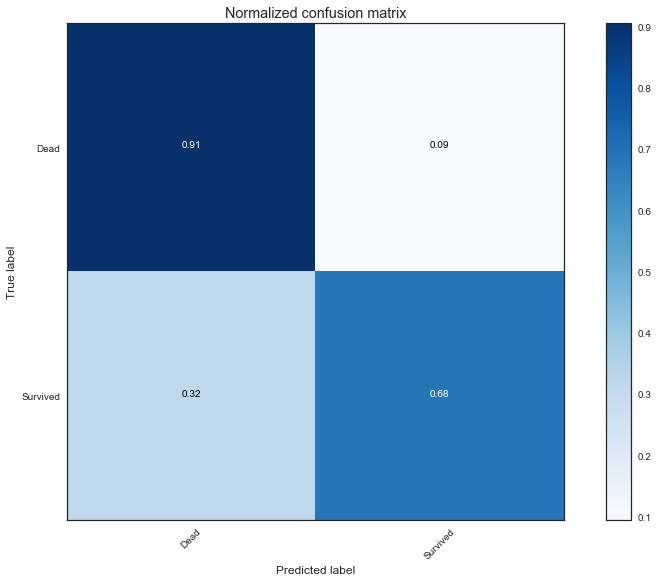

In [29]:
import itertools
import numpy as np

def plot_confusion_matrix(cm , classes , normalize = False,
                         title='Confusion matrix',
                         cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[: , np.newaxis]
        print('have normalize')
    else:
        print('no normalize')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [31]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_val_score(dtree,
                                  data1[data1_x_bin],
                                              data1[Target],
                                              cv=cv_split)
dtree.fit(data1[data1_x_bin , data1[Target]])


TypeError: unhashable type: 'list'

In [32]:
param_grid = {'criterion':['gini','entropy'],
             'max_depth':[2,4,6,8,10,None],
             'random_state':[0]}
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(),
                                         param_grid=param_grid,
                                         scoring = 'roc_auc',
                                         cv=cv_split)
tune_model.fit(data1[data1_x_bin] , data1[Target])

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.6),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, None], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [33]:
tune_model.best_params_

{'criterion': 'gini', 'max_depth': 4, 'random_state': 0}

In [34]:
dtree = tree.DecisionTreeClassifier(random_state=0)
dtree_rfe = feature_selection.RFECV(dtree , 
                                   step = 1,
                                   scoring='accuracy',
                                   cv=cv_split)

dtree_rfe.fit(data1[data1_x_bin] , data1[Target])

X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]
#X_rfe就是特征选择的结果
rfe_results = model_selection.cross_val_score(dtree , data1[X_rfe],data1[Target],
                                             cv=cv_split)

rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier() , 
                                             param_grid=param_grid,
                                             scoring='roc_auc',cv=cv_split)

rfe_tune_model.fit(data1[X_rfe] , data1[Target])

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.3, train_size=0.6),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, None], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [35]:
print(X_rfe)

['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']


In [38]:
import graphviz
dot_data = tree.export_graphviz(dtree , out_file=None,
                               feature_names=data1_x_bin , 
                               class_names=True,
                               filled = True , rounded=True)
graph = graphviz.Source(dot_data)
graph

AttributeError: 'NoneType' object has no attribute 'children_left'

In [39]:
correlation_heatmap(MLA_predict)

NameError: name 'correlation_heatmap' is not defined

In [41]:
vote_est = [
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    ('lr', linear_model.LogisticRegressionCV()),
    
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    ('knn', neighbors.KNeighborsClassifier()),
    
    ('svc', svm.SVC(probability=True)),
    
    ('xgb', XGBClassifier())
]

vote_hard = ensemble.VotingClassifier(estimators=vote_est , voting='hard')
vote_hard_cv = model_selection.cross_val_score(vote_hard ,
                                              data1[data1_x_bin],
                                              data1[Target],
                                              cv=cv_split)
vote_hard.fit(data1[data1_x_bin] , data1[Target])
print(vote_hard_cv)


vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_val_score(vote_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])
print(vote_soft_cv)

I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to che

I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

[0.84 0.81 0.82 0.81 0.83 0.82 0.79 0.82 0.83 0.85]


I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.83 0.81 0.81 0.82 0.84 0.82 0.8  0.82 0.82 0.86]


In [42]:
clf

NameError: name 'clf' is not defined

In [44]:
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])

    best_param = best_search.best_params_
    clf[1].set_params(**best_param) 



print('-'*10)

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarni

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarni

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarni

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
I:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn

I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
I:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

ValueError: Logistic Regression supports only liblinear, newton-cg, lbfgs and sag solvers, got saga

In [46]:
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_val_score(grid_hard, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_hard.fit(data1[data1_x_bin], data1[Target])

grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv  = cv_split)
grid_soft.fit(data1[data1_x_bin], data1[Target])

I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to che

I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

AttributeError: module 'sklearn.model_selection' has no attribute 'cross_validate'

In [48]:
data_val['Survived'] = mytree(data_val).astype(int)
data_val['Survived'] = grid_hard.predict(data_val[data1_x_bin])
submit = data_val[['PassengerId','Survived']]
submit.to_csv("submit11.csv", index=False)

I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
I:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
